In [270]:
import pickle as pkl

In [271]:
filename = "sim_results/market-marl-nash-3-04-29-2022-14-22-00250_results.pkl"

with open(filename, 'rb') as f:
    res = pkl.load(f)


In [272]:
l = list(dir(res))

In [273]:
import numpy as np
import seaborn as sns

In [274]:
import pandas as pd

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps, "Nash Net Loss": res.losses_nash}
data_losses_df = pd.DataFrame(data=data_losses)
# sns.lineplot(data=data_losses_df)

In [275]:
res.marl_params

{'epochs': 250,
 'explore_epsilon': 0.05,
 'max_steps': 35,
 'sync_freq': 30,
 'mem_size': 101333,
 'turbo_max_evals': 13,
 'turbo_batch_size': 13,
 'turbo_n_init': 13,
 'batch_size': 20}

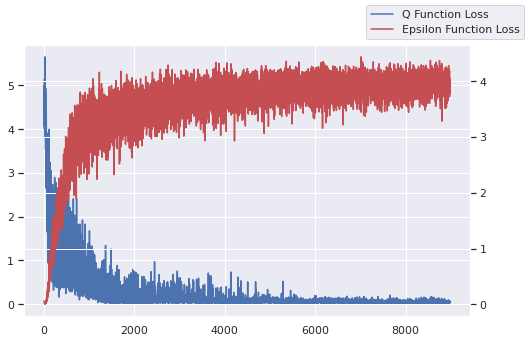

In [276]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()

# data_losses_df.plot(y="Nash Net Loss", ax=ax2, legend=False, color="r")
# ax.figure.legend()

data_losses_df.plot(y="Epsilon Function Loss", ax=ax2, legend=False, color="r")
ax.figure.legend()


In [277]:
# import matplotlib.pyplot as plt
# sns.lineplot(data=res.losses, color="b", legend="auto")
# ax2 = plt.twinx()
# sns.lineplot(data=res.losses_eps, color="g", ax=ax2)

<AxesSubplot:>

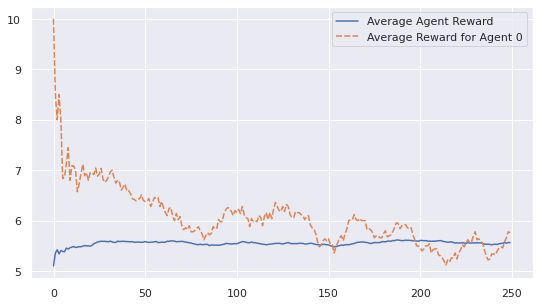

In [278]:
# Plot rewards

data_rewards = {"Average Agent Reward": res.avg_epoch_rewards, "Average Reward for Agent 0": res.avg_epoch_rewards_agent}
data_rewards_df = pd.DataFrame(data=data_rewards)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=data_rewards_df)

In [279]:
from environment.TheoreticalMarket import *
import numpy as np

# Theoretical Data
# tm = TheoreticalMarket(beta0 = 30, beta1 = -1.1, beta2 = -2, a = 0.1, ref_p = 1.5)
beta0 = 25
beta1 = -0.9
beta2 = -1.1
a = 0.1

# Simulation Data
ep = 2
ref_prices = res.state_tracker_epoch[ep]
# ref_prices = res.state_tracker[ep]
episode_rewards = res.episode_rewards[ep]
# joint_actions = res.episode_actions

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

# min_eps_price, max_eps_price = get_eps0_range(9.9, Y, X, z)

nash_eps_bounds = [get_eps0_range(ref_price, Y, X, z) for ref_price in ref_prices ]
nash_lower_bound =  [v[0] for v in nash_eps_bounds]
nash_upper_bound =  [v[1] for v in nash_eps_bounds]

# Episode rewards 


In [281]:
avg_ag_rewards = episode_rewards.mean(axis = 1)

<AxesSubplot:>

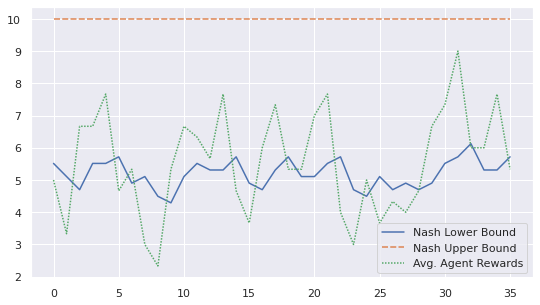

In [282]:
# "Ref Prices": ref_prices, 
nash_bound_per_run = {"Nash Lower Bound": nash_lower_bound, "Nash Upper Bound": nash_upper_bound, "Avg. Agent Rewards": avg_ag_rewards}
nash_bound_per_run_df = pd.DataFrame(data=nash_bound_per_run)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=nash_bound_per_run_df)

In [283]:
nash_bound_per_run_df

,Nash Lower Bound,Nash Upper Bound,Avg. Agent Rewards
0,5.514694,10.0,5.000000
1,5.106939,10.0,3.333333
2,4.699184,10.0,6.666667
3,5.514694,10.0,6.666667
4,5.514694,10.0,7.666667
5,5.718571,10.0,4.666667
6,4.903061,10.0,5.333333
7,5.106939,10.0,3.000000
8,4.495306,10.0,2.333333
9,4.291429,10.0,5.333333


In [284]:
res.episode_rewards[0]

array([[ 6.,  7.,  2.],
       [ 1.,  6.,  3.],
       [ 2.,  2.,  7.],
       [10.,  6.,  5.],
       [ 7.,  8.,  4.],
       [ 8.,  3.,  4.],
       [ 2.,  4.,  8.],
       [ 9.,  5.,  7.],
       [ 5.,  2.,  5.],
       [ 1., 10.,  1.],
       [ 4.,  1.,  9.],
       [10.,  5.,  5.],
       [ 3., 10.,  9.],
       [ 1.,  1.,  8.],
       [ 8.,  7.,  2.],
       [ 1.,  5.,  5.],
       [ 7.,  2.,  4.],
       [ 4.,  4.,  2.],
       [ 1.,  5.,  6.],
       [10.,  6.,  2.],
       [ 1.,  2., 10.],
       [ 9.,  8.,  7.],
       [ 3.,  5.,  3.],
       [ 8.,  3.,  1.],
       [ 3.,  5.,  5.],
       [ 3.,  4.,  7.],
       [ 6.,  9., 10.],
       [ 9.,  2.,  5.],
       [ 4.,  6.,  6.],
       [ 1.,  6., 10.],
       [10.,  3., 10.],
       [ 4., 10.,  4.],
       [ 6.,  3.,  5.],
       [ 5.,  3.,  2.],
       [ 6.,  5.,  2.],
       [10.,  2.,  3.]])

In [285]:
state_key = [0.0, 0.0, 0.0, 3.0]

res.sna_policy_dict_iter[repr(state_key)][0]

In [286]:
max_p = 0
agent_id = 0
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)

0.3478517946547349
0.6335756857741581
0.6359269526221409
0.08148185906663928
0.6817736243180409
0.42908891730462845
0.6013350135641373
0.6414572581470349
0.575896999342749
0.6725951584913056
4


In [287]:
max_p = 0
agent_id = 1
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.7113337059100484
0.8912447002933037
0.32778204221032303
0.40909802966025616
0.3107627876091976
0.5800652797673918
0.7682772189825048
0.604964104554882
0.8569960206934872
0.3288720942319116
1


In [288]:
max_p = 0
agent_id = 2
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.9757424765186318
0.20384092122845232
0.9476827858110829
0.551130939485392
0.4473501283439247
0.8548116346276927
0.0532464284434276
0.763215464921575
0.14868399669934876
0.2229944387572979
0


In [289]:
res.state_tracker

AttributeError: 'ResultObj' object has no attribute 'state_tracker'